# Préparation du dataset

## Import du dataset

In [ ]:
import time,datetime
start_time = time.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm_notebook, tnrange
from tqdm.contrib import tenumerate

%matplotlib inline
from os import listdir

from scipy.optimize import linear_sum_assignment
from collections import Counter

import joblib

######### Sklearn  #################

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# metrics
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
path =  "/content/drive/MyDrive/Colab_Notebooks/Project_6/Flipkart/Images/"
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1056


In [ ]:
Flipkart = pd.read_csv('..//flipkart_com-ecommerce_sample_1050.csv',encoding='iso-8859-1')
Flipkart.head(5)

dataset=Flipkart[['product_category_tree','image']].copy()

In [ ]:
# Renommage des catégories (legendes des matrices de confusion trop longues)
shorten={'Watches ':'Watches',
         'Computers ':'Computers',
         'Home Decor & Festive Needs ':'Decor',
         'Kitchen & Dining ':'Kitchen',
         'Home Furnishing ':'Furniture',
         'Beauty and Personal Care ':'Beauty',
         'Baby Care ':'Baby'}

In [ ]:
# extraction du premier etage de l'arbre category affichages des occurences
dataset['category']=dataset.product_category_tree.apply(lambda s : s[2:s.find('>>')])
cat=pd.DataFrame(dataset.category.value_counts())
cat.reset_index(inplace=True)
cat['category'] = cat['category'].replace(shorten)
cat

,category,count
0,Furniture,150
1,Baby,150
2,Watches,150
3,Decor,150
4,Kitchen,150
5,Beauty,150
6,Computers,150


In [ ]:
# Shorten category names
dataset['category']= dataset['category'].replace(shorten)
dataset.category.value_counts()

,count
category,
Furniture,150
Baby,150
Watches,150
Decor,150
Kitchen,150
Beauty,150
Computers,150


In [ ]:
# dictionaire pour ordinal encoding des noms de categories
# permatra de comparer avec les resultast du clustering
dico={cat.loc[i,'category']:i for i in cat.index}
dico_reverse={i:cat.loc[i,'category'] for i in cat.index}
display(dico)

# affectation à la colonne cat_code
dataset['cat_code']=dataset.category.map(dico)

# Essayer avec un transformer labelencoder pour encodage decodage

{'Furniture': 0,
 'Baby': 1,
 'Watches': 2,
 'Decor': 3,
 'Kitchen': 4,
 'Beauty': 5,
 'Computers': 6}

In [ ]:
data=dataset[['category','cat_code','image']].copy()
# data=dataset[['category','cat_code','image']].sample(100)

data.head(2)

,category,cat_code,image
0,Furniture,0,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby,1,7b72c92c2f6c40268628ec5f14c6d590.jpg


## Création des labels des photos à partir du nom des images

In [ ]:
data.groupby('cat_code').count()

,category,image
cat_code,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


## Affichage d'exemples d'images par label

In [ ]:
from matplotlib.image import imread

for categ in set(data.category):
    plt.figure(figsize=(12,4))
    print('Sample category : {} '.format(categ))
    image_sample=data[data.category == categ].image.sample(3)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + image_sample.iloc[i]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Fonctions d'évaluation des clusters

from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from scipy.optimize import linear_sum_assignment
from collections import Counter

# Plot confusion matrix with better cmap look.
def plot_conf_mat(matrix,y_names,x_names,title=''):
    fig,axe=plt.subplots(figsize=(8,6))

    sns.heatmap(matrix, annot=True, cmap='Accent',ax=axe, square=True,fmt='g',vmin=0,vmax=150)
    axe.set_yticklabels(y_names,rotation = 0,fontsize=11)
    axe.set_xticklabels(x_names, rotation = 45, ha="right",fontsize=11)
    axe.set_title(title,fontsize=16)
    plt.show()


"""
Main function.
Evaluates clustering performance by comparing predicted cluster labels with ground truth labels.

This function performs several key evaluation steps:
1. Counts the frequency of each cluster
2. Computes a confusion matrix between predicted clusters and true categories
3. Optimizes cluster-to-category alignment using the Hungarian algorithm
4. Visualizes the aligned confusion matrix
5. Calculates the Adjusted Rand Index (ARI) to measure clustering quality
6. Generates a detailed classification report with precision, recall, and F1-score

Parameters:
    pred_labels (array-like): Predicted cluster labels from clustering algorithm
    true_labels (array-like): Ground truth category labels
    cat_names (list): List of category names for visualization and reporting

Returns:
    tuple: ((precision, recall, f1, support), ari) - Macro-averaged metrics and ARI score
"""
def clustering_evaluate(pred_labels, true_labels, cat_names):

    # Count clusters effectives
    effectives=dict(sorted(Counter(pred_labels).items()))

    # compute confusion matrix
    conf_mat=confusion_matrix(true_labels,pred_labels)

    # Plot confusion matrix
#     plot_conf_mat(conf_mat,cat['index'],range(7),title='Confusion matrix')

    # Maximize values on first diagonal
    row_ind, col_ind = linear_sum_assignment(conf_mat,maximize=True)
    permut = pd.DataFrame(col_ind,index=cat['category'],columns=['cluster'])
    permut.index.rename('Category',inplace=True)
    permut['effectives']=[effectives[cls] for cls in permut.cluster]
    display(permut)
    cm=conf_mat.take(col_ind,axis=1)

    # Plot aligned confusion matrix
    plot_conf_mat(cm,cat_names,cat_names,title='Aligned confusion matrix')

    # Align cluster label on category code   [corresp[cls] for cls in labels]
    corresp = np.argmax(conf_mat, axis=0)

    # print  adjusted rand score
    ari = adjusted_rand_score(true_labels,pred_labels)
    print(' ARI : {}'.format(ari))

    # Print classification report
    print(classification_report(true_labels,
                                [corresp[cls] for cls in pred_labels],
                                target_names=cat_names,
                                zero_division=0)
         )
    return  precision_recall_fscore_support(true_labels,
                                [corresp[cls] for cls in pred_labels],
                                             average='macro', zero_division=0), ari

# 2D projection scatterplot
def plot_clusters(reduced,labels):
    data=pd.DataFrame(np.c_[reduced,labels],columns=['Component 1','Component 2','Cluster'])

    plt.figure(figsize=(10,8))
    sns.scatterplot(data=data,
                    x='Component 1',
                    y='Component 2',
                    hue='Cluster',
                    palette=sns.color_palette('tab10', n_colors=7))
    plt.title(f'')
    plt.figure(figsize=(10,8))

In [ ]:
def view_cluster(pred_labels):
    # Dict to hold the cluster id and the images { id: [images] }
    groups_per = {}
    print('Create groups of images per cluster...')
    # Filling groups
    for file, cluster in zip(data.image,pred_labels):
        if cluster not in groups_per.keys():
            groups_per[cluster] = []
            groups_per[cluster].append(file)
        else:
            groups_per[cluster].append(file)
    print('done.')

    # loops on clusters for content sample
    for cluster in tnrange(7,desc='Printing images by cluster'):
        plt.figure(figsize = (25,25));
        # gets the list of filenames for a cluster
        files = groups_per[cluster]
        # only allow up to 30 images to be shown at a time
        if len(files) > 30:
            print(f"Clipping cluster {cluster} size from {len(files)} to 30")
            files = files[:29]
        else:
            print(f"Cluster {cluster} size {len(files)}")
        # plot each image in the cluster
        for index, file in enumerate(files):
            plt.subplot(10,10,index+1);
            img = load_img(path+file)
            img = np.array(img)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

## Core functions

In [ ]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle


def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(path+file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx)
    return features

def extract_cnn_features_batch(model,image_list,vector_length):
    data_ = {}
    save_path = r"./FEATURE_VECTORS"

    # lop through each image in the dataset
    # for image in data.image:
    for _ , image in tenumerate(image_list,desc='Feature extraction '):
        # try to extract the features and update the dictionary
        try:
            feat = extract_features(image,model)
#         print(i_,feat.shape)
            data_[image] = feat
        # if something fails, save the extracted features as a pickle file (optional)
        except:
            print('On {} feature extraction failed'.format(image))
            with open(save_path,'wb') as file:
                pickle.dump(data_,file)

    # get a list of just the features
    feat = np.array(list(data_.values()))

    # reshape so that there are 1050 samples of 4096 vectors
    feat = feat.reshape(-1,vector_length)
    print('Features extracted {}'.format(feat.shape))
    return feat

def pca_reduction_and_clustering(features):
    # reduce the amount of dimensions in the feature vector
    print("Dimensions dataset avant réduction PCA : ", features.shape)
    pca = PCA(n_components=.99, random_state=22)
    pca.fit(features)
    X = pca.transform(features)
    print("Dimensions dataset après réduction PCA : ", X.shape)

    # cluster on feature vectors
    print('Computing clusters....')
    # kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
    kmeans = KMeans(n_clusters=7, random_state=22)
    kmeans.fit(X)
    print('done.')
    return kmeans.labels_

In [ ]:
# Dictionary to hold results
# Function to append results to result_dict
def append_dict(dict1_obj, dict2_obj):
    for key in dict1_obj.keys():
        dict1_obj[key].append(dict2_obj[key])

# Initialize VGG16 results dictionary
vgg16_results={'title' : [], 'metrics':[]}


# Initialize ResNet50 results dictionary
rn50_results={'title' : [], 'metrics':[]}


# Extract CNN features

## VGG16

In [ ]:
# models
from keras.applications.vgg16 import VGG16
# Import specific preprocess for that model from keras
from keras.applications.vgg16 import preprocess_input

In [ ]:
# Downloading VGG16 model
vgg16 = VGG16()
model = Model(inputs = vgg16.input, outputs = vgg16.layers[-2].output)

In [ ]:
# Pictures features extraction (faster with GPU enabled)
print('         Model VGG16 ')
feat_vgg16 = extract_cnn_features_batch(model,data.image,4096)
joblib.dump(feat_vgg16,'./FEAT_VGG16')

         Model VGG16 


Feature extraction :   0%|          | 0/1050 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

['./FEAT_VGG16']

In [ ]:
feat_vgg16 = joblib.load('./FEAT_VGG16')

## ResNet50

In [ ]:
# Import pretrained model from Keras
from keras.applications.resnet50 import ResNet50
# Import specific preprocess for that model from keras
from keras.applications.resnet50 import preprocess_input

In [ ]:
# Remove classification layers for feature extraction
resnet50 = ResNet50()
model = Model(inputs = resnet50.input, outputs = resnet50.layers[-2].output)

In [ ]:
print('         Model ResNet50 ')
# Extract features for all images in dataset
feat_resnet50 = extract_cnn_features_batch(model,data.image,2048)
joblib.dump(feat_resnet50,'./FEAT_ResNet50')

         Model ResNet50 


Feature extraction :   0%|          | 0/1050 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━

['./FEAT_ResNet50']

In [ ]:
feat_resnet50 = joblib.load('./FEAT_ResNet50')

# Clustering

### No Projection

#### VGG16

,cluster,effectives
Category,,
Furniture,4,75
Baby,0,205
Watches,3,129
Decor,1,276
Kitchen,2,77
Beauty,6,99
Computers,5,189


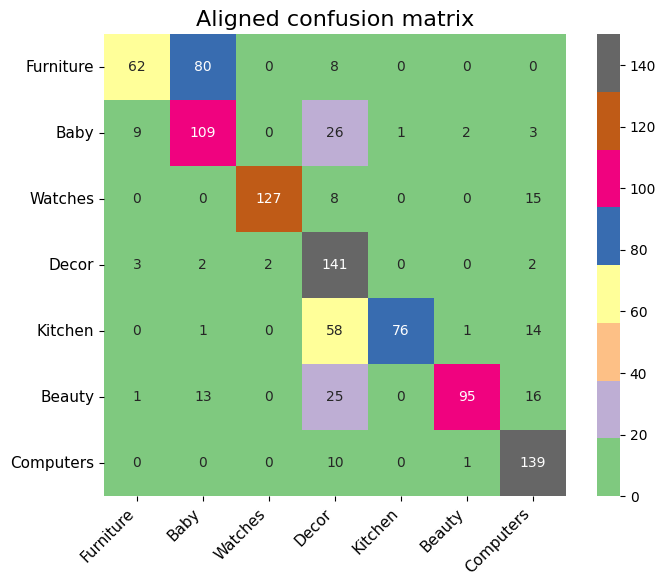

 ARI : 0.4773524941387263
              precision    recall  f1-score   support

   Furniture       0.83      0.41      0.55       150
        Baby       0.53      0.73      0.61       150
     Watches       0.98      0.85      0.91       150
       Decor       0.51      0.94      0.66       150
     Kitchen       0.99      0.51      0.67       150
      Beauty       0.96      0.63      0.76       150
   Computers       0.74      0.93      0.82       150

    accuracy                           0.71      1050
   macro avg       0.79      0.71      0.71      1050
weighted avg       0.79      0.71      0.71      1050



In [ ]:
model_vgg16=KMeans(n_clusters=7, random_state=42,n_init=30)
model_vgg16.fit(feat_vgg16)


labels=model_vgg16.labels_

title='VGG16'
# Evaluate and store metrics results)
append_dict(vgg16_results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )

#### ResNet50

,cluster,effectives
Category,,
Furniture,2,75
Baby,0,205
Watches,3,140
Decor,1,280
Kitchen,6,78
Beauty,4,106
Computers,5,166


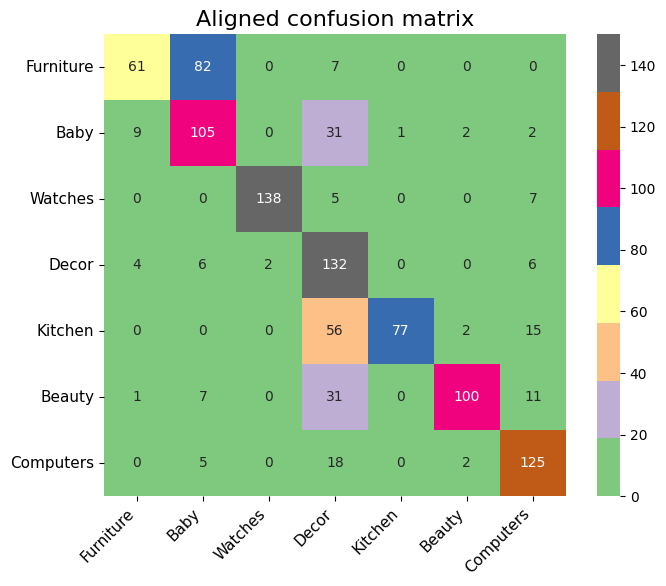

 ARI : 0.4631626449892587
              precision    recall  f1-score   support

   Furniture       0.81      0.41      0.54       150
        Baby       0.51      0.70      0.59       150
     Watches       0.99      0.92      0.95       150
       Decor       0.47      0.88      0.61       150
     Kitchen       0.99      0.51      0.68       150
      Beauty       0.94      0.67      0.78       150
   Computers       0.75      0.83      0.79       150

    accuracy                           0.70      1050
   macro avg       0.78      0.70      0.71      1050
weighted avg       0.78      0.70      0.71      1050

Clustering sur ResNet50


In [ ]:
model_rn50=KMeans(n_clusters=7, random_state=42,n_init=30)
model_rn50.fit(feat_resnet50)


labels=model_rn50.labels_

title='ResNet50'
# Evaluate and store metrics results)
append_dict(rn50_results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering sur '+title)

## Projection

### Projections

#### PCA

* **Linear space transformation**: PCA projects data into a new coordinate system defined by orthogonal directions of maximum variance
* **Dimensionality optimization**: Reduces feature redundancy by identifying and preserving only the most informative dimensions
* **Noise reduction effect**: Lower-ranked components often capture noise, so eliminating them increases signal-to-noise ratio
* **Global pattern prioritization**: Emphasizes broad patterns that explain the largest sources of variation across documents
* **Feature correlation resolution**: Addresses multicollinearity by creating uncorrelated components from correlated original features
* **Variance-based information retention**: Provides clear metrics on how much information (variance) is preserved in the reduced space

##### VGG16 + PCA

,cluster,effectives
Category,,
Furniture,5,230
Baby,0,181
Watches,3,94
Decor,6,138
Kitchen,1,135
Beauty,4,65
Computers,2,207


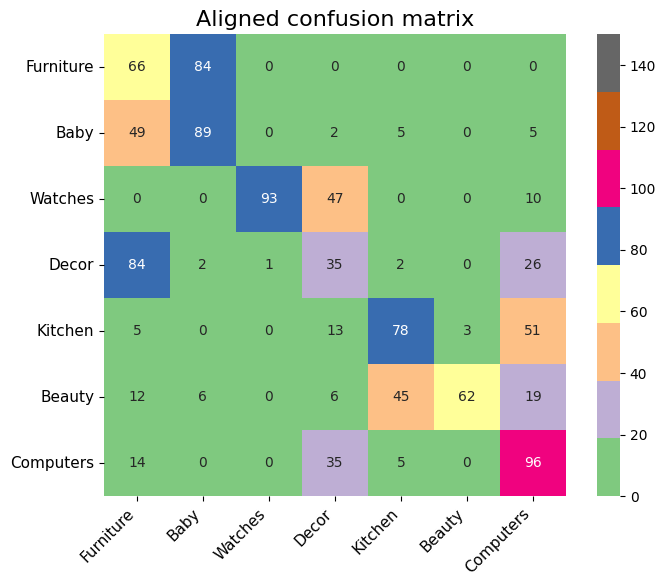

 ARI : 0.2918563774840129
              precision    recall  f1-score   support

   Furniture       0.00      0.00      0.00       150
        Baby       0.49      0.59      0.54       150
     Watches       0.60      0.93      0.73       150
       Decor       0.37      0.56      0.44       150
     Kitchen       0.58      0.52      0.55       150
      Beauty       0.95      0.41      0.58       150
   Computers       0.46      0.64      0.54       150

    accuracy                           0.52      1050
   macro avg       0.49      0.52      0.48      1050
weighted avg       0.49      0.52      0.48      1050

Clustering on VGG16 + PCA (2 components, 14.53% explained variance)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Create full PCA model to calculate explained variance
pca_full = PCA(random_state=42)
pca_full.fit(feat_vgg16)

# Calculate cumulative variance explained by the first 2 components
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
variance_2_components = cumulative_variance[1] * 100

# Apply PCA with 2 components for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
bow_pca = pca.fit_transform(feat_vgg16)

# K-Means clustering on reduced data
kmeans2_vgg16 = KMeans(n_clusters=7, random_state=42, n_init=30).fit(bow_pca)
labels = kmeans2_vgg16.labels_

# Title including explained variance
title = f'VGG16 + PCA (2 components, {variance_2_components:.2f}% explained variance)'

# Evaluate and store metrics results
append_dict(vgg16_results, {
    'title': title,
    'metrics': clustering_evaluate(labels, data.cat_code, cat['category'])
})

# Display clustering results
print(f'Clustering on {title}')

##### ResNet50 + PCA

,cluster,effectives
Category,,
Furniture,5,173
Baby,0,196
Watches,3,137
Decor,6,126
Kitchen,4,143
Beauty,1,77
Computers,2,198


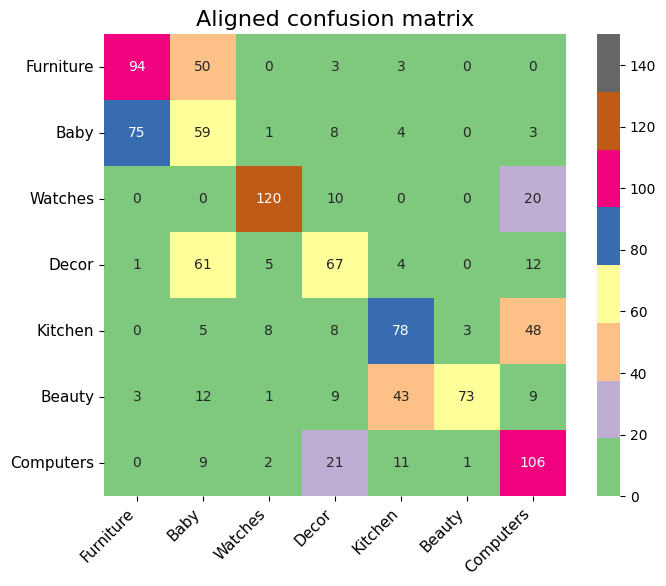

 ARI : 0.33959600430831316
              precision    recall  f1-score   support

   Furniture       0.54      0.63      0.58       150
        Baby       0.00      0.00      0.00       150
     Watches       0.88      0.80      0.84       150
       Decor       0.40      0.85      0.54       150
     Kitchen       0.55      0.52      0.53       150
      Beauty       0.95      0.49      0.64       150
   Computers       0.54      0.71      0.61       150

    accuracy                           0.57      1050
   macro avg       0.55      0.57      0.54      1050
weighted avg       0.55      0.57      0.54      1050

Clustering on ResNet50 + PCA (2 components, 11.98% explained variance)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Create full PCA model to calculate explained variance
pca_full = PCA(random_state=42)
pca_full.fit(feat_resnet50)

# Calculate cumulative variance explained by the first 2 components
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
variance_2_components = cumulative_variance[1] * 100

# Apply PCA with 2 components for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
bow_pca = pca.fit_transform(feat_resnet50)

# K-Means clustering on reduced data
kmeans2_rn50 = KMeans(n_clusters=7, random_state=42, n_init=30).fit(bow_pca)
labels = kmeans2_rn50.labels_

# Title including explained variance
title = f'ResNet50 + PCA (2 components, {variance_2_components:.2f}% explained variance)'

# Evaluate and store metrics results
append_dict(rn50_results, {
    'title': title,
    'metrics': clustering_evaluate(labels, data.cat_code, cat['category'])
})

# Display clustering results
print(f'Clustering on {title}')

#### TSNE

* **Optimized spatial reorganization**: t-SNE transforms the vector space by preserving local similarities while amplifying differences between distinct groups
* **Curse of dimensionality mitigation**: Addresses the "curse of dimensionality" problem that affects high-dimensional TF-IDF vectors, where distance metrics become less meaningful
* **Adaptation to textual complexity**: Unlike linear methods, t-SNE adapts to complex and non-linear structures present in textual data
* **Dimensional noise elimination**: Reduction to 2D eliminates non-relevant dimensions that hindered K-means performance in the original sparse vector space
* **Enhancement of natural boundaries**: The transformation accentuates natural separations between categories, considerably facilitating the clustering algorithm's task

##### VGG16 + TSNE

,cluster,effectives
Category,,
Furniture,4,106
Baby,0,183
Watches,6,144
Decor,1,171
Kitchen,2,85
Beauty,3,130
Computers,5,231


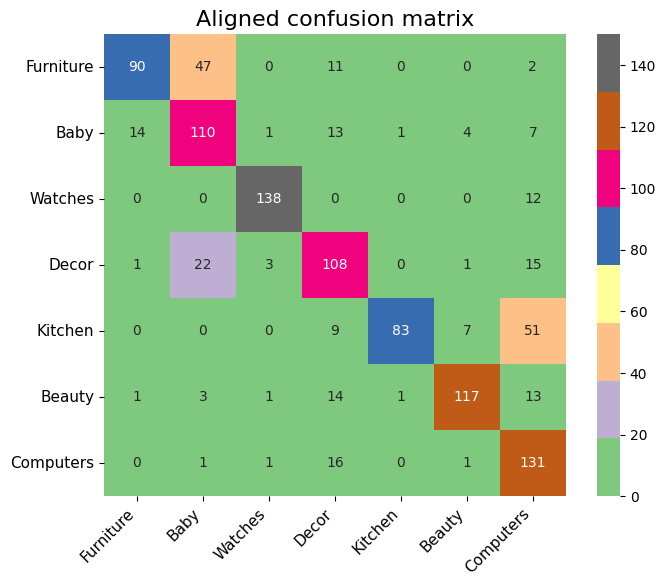

 ARI : 0.5038912702392225
              precision    recall  f1-score   support

   Furniture       0.85      0.60      0.70       150
        Baby       0.60      0.73      0.66       150
     Watches       0.96      0.92      0.94       150
       Decor       0.63      0.72      0.67       150
     Kitchen       0.98      0.55      0.71       150
      Beauty       0.90      0.78      0.84       150
   Computers       0.57      0.87      0.69       150

    accuracy                           0.74      1050
   macro avg       0.78      0.74      0.74      1050
weighted avg       0.78      0.74      0.74      1050

Clustering on VGG16 + T-SNE 2 components


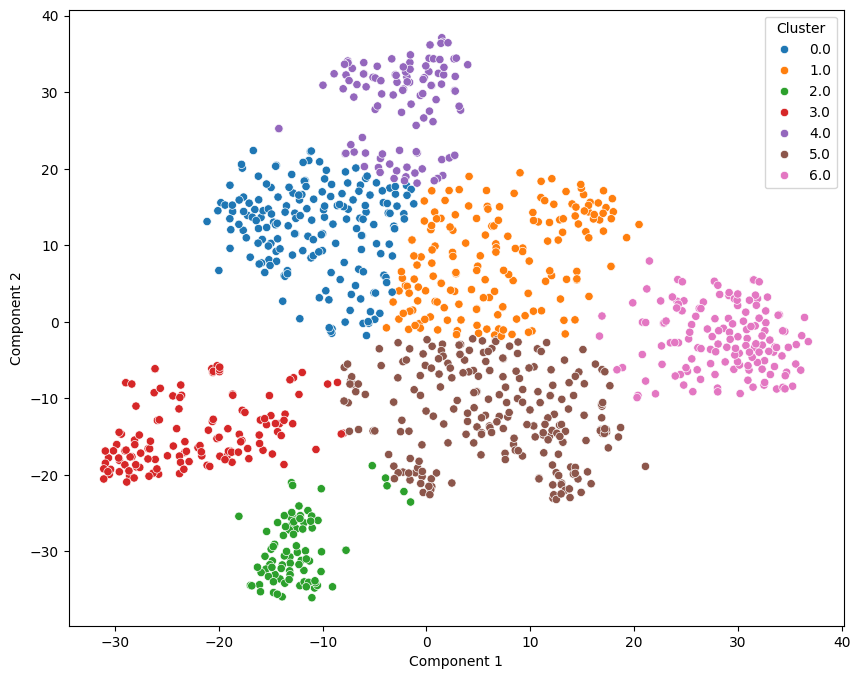

<Figure size 1000x800 with 0 Axes>

In [ ]:
from sklearn.manifold import TSNE
# tok variable comes from the countvectorizer + tfidf section
vgg16_tsne = TSNE(n_components=2,
                perplexity=50,
                early_exaggeration=12.0,
                learning_rate=200.0,
                max_iter=1000,
                n_iter_without_progress=300,
                min_grad_norm=1e-07,
                metric='euclidean',
                init='random',   # pca
                verbose=0,
                random_state=42,
                method='barnes_hut',   # exact
                angle=0.2,
                n_jobs=-1
               ).fit_transform(feat_vgg16)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans3_vgg16 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(vgg16_tsne)
    # Assign clusters
labels=kmeans3_vgg16.labels_

title='VGG16 + T-SNE 2 components'
# Evaluate and store metrics results)
append_dict(vgg16_results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(vgg16_tsne,labels)

##### ResNet50 + TSNE

,cluster,effectives
Category,,
Furniture,3,121
Baby,2,184
Watches,0,172
Decor,5,130
Kitchen,1,140
Beauty,6,133
Computers,4,170


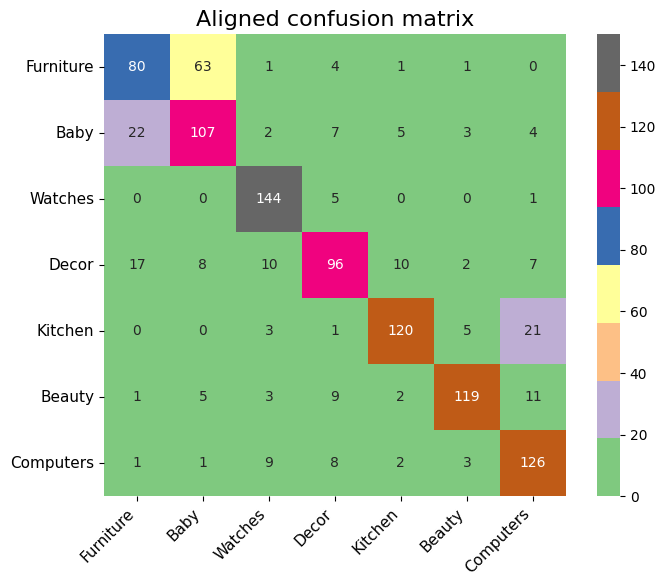

 ARI : 0.5498575867867826
              precision    recall  f1-score   support

   Furniture       0.66      0.53      0.59       150
        Baby       0.58      0.71      0.64       150
     Watches       0.84      0.96      0.89       150
       Decor       0.74      0.64      0.69       150
     Kitchen       0.86      0.80      0.83       150
      Beauty       0.89      0.79      0.84       150
   Computers       0.74      0.84      0.79       150

    accuracy                           0.75      1050
   macro avg       0.76      0.75      0.75      1050
weighted avg       0.76      0.75      0.75      1050

Clustering on ResNet50 + T-SNE 2 components


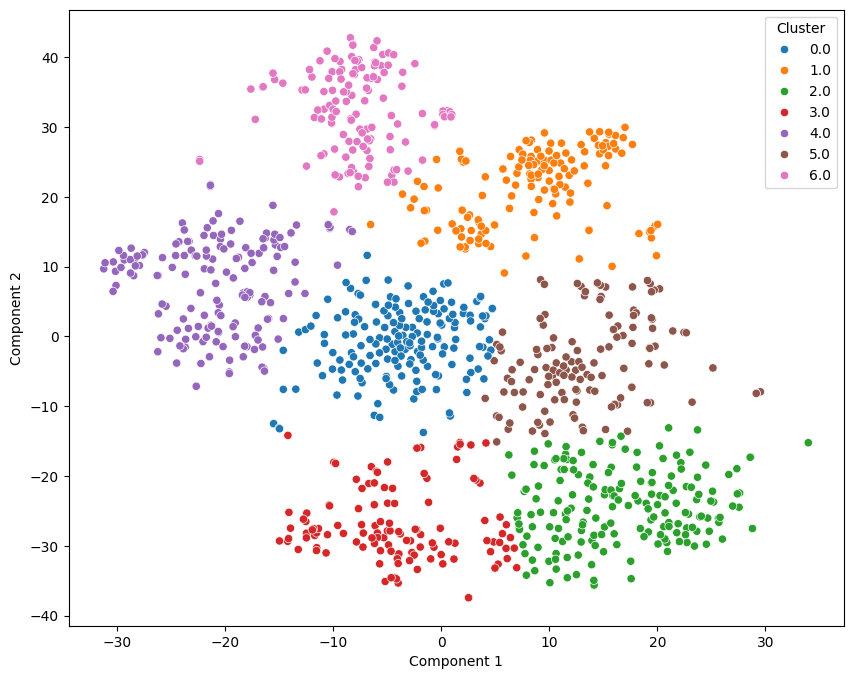

<Figure size 1000x800 with 0 Axes>

In [ ]:
from sklearn.manifold import TSNE
# tok variable comes from the countvectorizer + tfidf section
rn50_tsne = TSNE(n_components=2,
                perplexity=50,
                early_exaggeration=12.0,
                learning_rate=200.0,
                max_iter=1000,
                n_iter_without_progress=300,
                min_grad_norm=1e-07,
                metric='euclidean',
                init='random',   # pca
                verbose=0,
                random_state=42,
                method='barnes_hut',   # exact
                angle=0.2,
                n_jobs=-1
               ).fit_transform(feat_resnet50)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans3_sn50 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(rn50_tsne)
    # Assign clusters
labels=kmeans3_sn50.labels_

title='ResNet50 + T-SNE 2 components'
# Evaluate and store metrics results)
append_dict(rn50_results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(rn50_tsne,labels)

#### MDS

* **Distance preservation focus**: Maintains pairwise distances between documents in lower-dimensional space
* **Global relationship retention**: Preserves overall structure of document relationships
* **Similarity visualization**: Transforms abstract similarities into interpretable spatial relationships
* **Stress minimization**: Optimizes projection by minimizing distortion in distance representation
* **Metric integrity**: Provides faithful representation of original document dissimilarities
* **Euclidean interpretation**: Projected distances correspond meaningfully to original feature differences

##### VGG16 + MDS

,cluster,effectives
Category,,
Furniture,3,159
Baby,4,167
Watches,1,149
Decor,5,114
Kitchen,6,123
Beauty,2,145
Computers,0,193


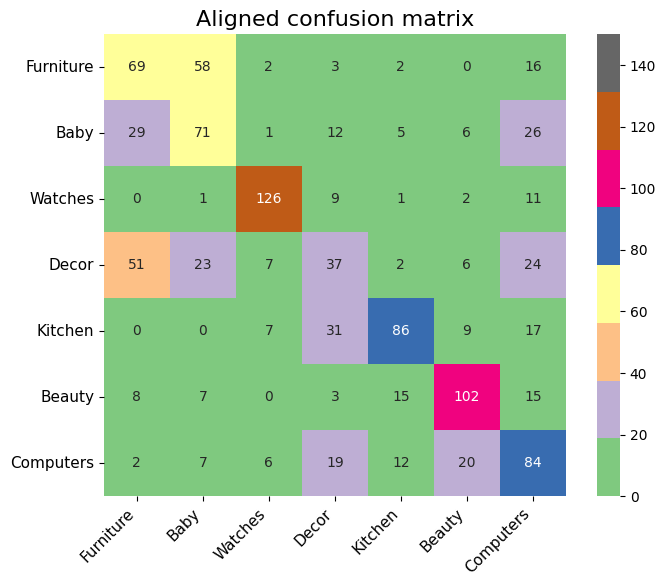

 ARI : 0.29710089051287253
              precision    recall  f1-score   support

   Furniture       0.43      0.46      0.45       150
        Baby       0.43      0.47      0.45       150
     Watches       0.85      0.84      0.84       150
       Decor       0.32      0.25      0.28       150
     Kitchen       0.70      0.57      0.63       150
      Beauty       0.70      0.68      0.69       150
   Computers       0.44      0.56      0.49       150

    accuracy                           0.55      1050
   macro avg       0.55      0.55      0.55      1050
weighted avg       0.55      0.55      0.55      1050

Clustering on VGG16 + MDS 2 components


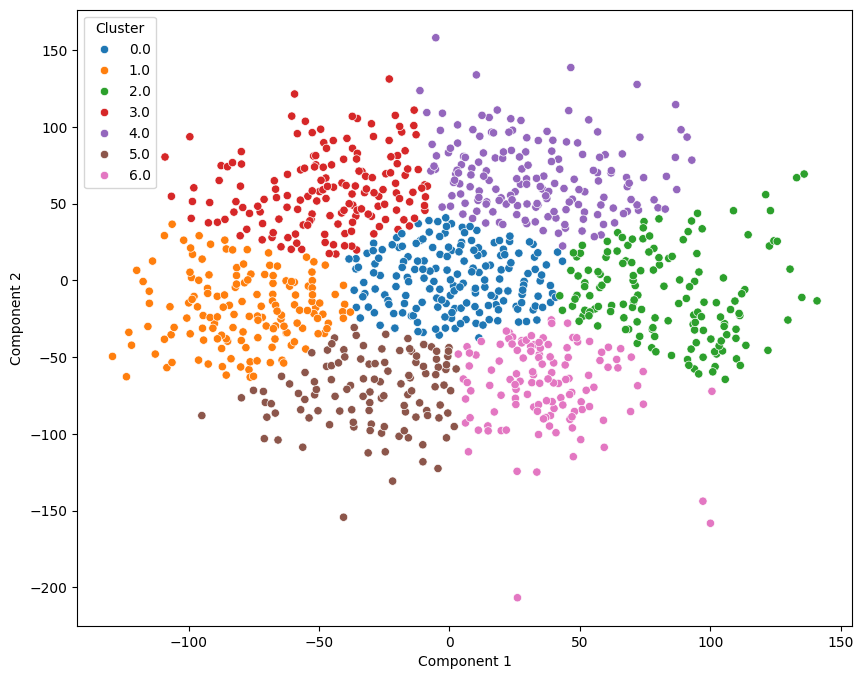

<Figure size 1000x800 with 0 Axes>

In [ ]:
from sklearn.manifold import MDS
vgg16_mds = MDS(n_components=2,
              metric=True,
              n_init=4,
              max_iter=300,
              verbose=0,
              eps=0.001,
              n_jobs=-1,
              random_state=42,

             ).fit_transform(feat_vgg16)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans4_vgg16 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(vgg16_mds)
    # Assign clusters
labels=kmeans4_vgg16.labels_

title='VGG16 + MDS 2 components'
# Evaluate and store metrics results)
append_dict(vgg16_results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(vgg16_mds,labels)

##### ResNet50 + MDS

,cluster,effectives
Category,,
Furniture,3,139
Baby,5,155
Watches,6,143
Decor,1,130
Kitchen,0,147
Beauty,2,181
Computers,4,155


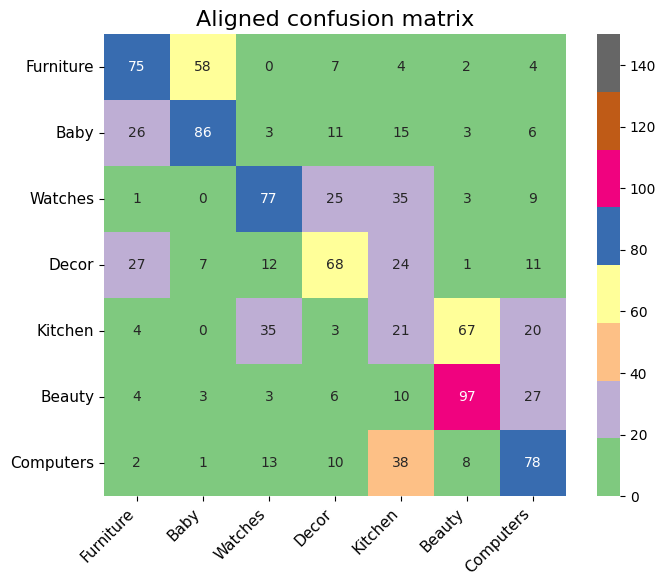

 ARI : 0.24418936798262006
              precision    recall  f1-score   support

   Furniture       0.54      0.50      0.52       150
        Baby       0.55      0.57      0.56       150
     Watches       0.54      0.51      0.53       150
       Decor       0.52      0.45      0.49       150
     Kitchen       0.00      0.00      0.00       150
      Beauty       0.54      0.65      0.59       150
   Computers       0.38      0.77      0.51       150

    accuracy                           0.49      1050
   macro avg       0.44      0.49      0.46      1050
weighted avg       0.44      0.49      0.46      1050

Clustering on ResNet50 + MDS 2 components


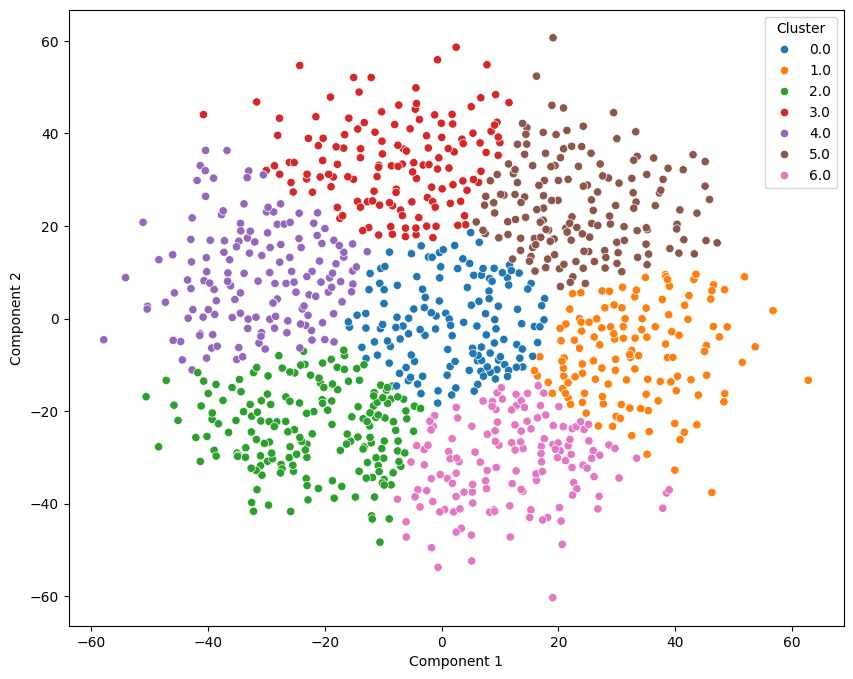

<Figure size 1000x800 with 0 Axes>

In [ ]:
from sklearn.manifold import MDS
rn50_mds = MDS(n_components=2,
              metric=True,
              n_init=4,
              max_iter=300,
              verbose=0,
              eps=0.001,
              n_jobs=-1,
              random_state=42,

             ).fit_transform(feat_resnet50)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans4_rn50 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(rn50_mds)
    # Assign clusters
labels=kmeans4_rn50.labels_

title='ResNet50 + MDS 2 components'
# Evaluate and store metrics results)
append_dict(rn50_results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(rn50_mds,labels)

#### SpectralEmbedding

* **Graph-based approach**: Leverages connectivity patterns between documents for dimensionality reduction
* **Non-linear manifold learning**: Captures intrinsic geometric structure of the document space
* **Eigenvector foundation**: Uses the most significant eigenvectors of the graph Laplacian matrix
* **Community detection strength**: Excels at revealing natural groupings and thematic communities
* **Connectivity preservation**: Maintains connected components from the high-dimensional space
* **Local-to-global mapping**: Builds global representation from local neighborhood information

##### VGG16 + SpectralEmbedding

,cluster,effectives
Category,,
Furniture,0,292
Baby,6,64
Watches,5,85
Decor,1,48
Kitchen,4,64
Beauty,2,61
Computers,3,436


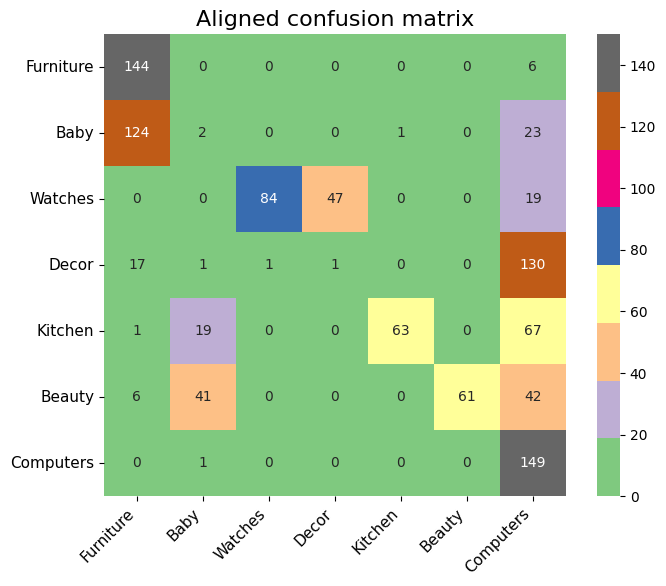

 ARI : 0.31867357220220105
              precision    recall  f1-score   support

   Furniture       0.49      0.96      0.65       150
        Baby       0.00      0.00      0.00       150
     Watches       0.98      0.87      0.93       150
       Decor       0.00      0.00      0.00       150
     Kitchen       0.98      0.42      0.59       150
      Beauty       0.82      0.68      0.74       150
   Computers       0.34      0.99      0.51       150

    accuracy                           0.56      1050
   macro avg       0.52      0.56      0.49      1050
weighted avg       0.52      0.56      0.49      1050

Clustering on VGG16 + Spectral 2 components


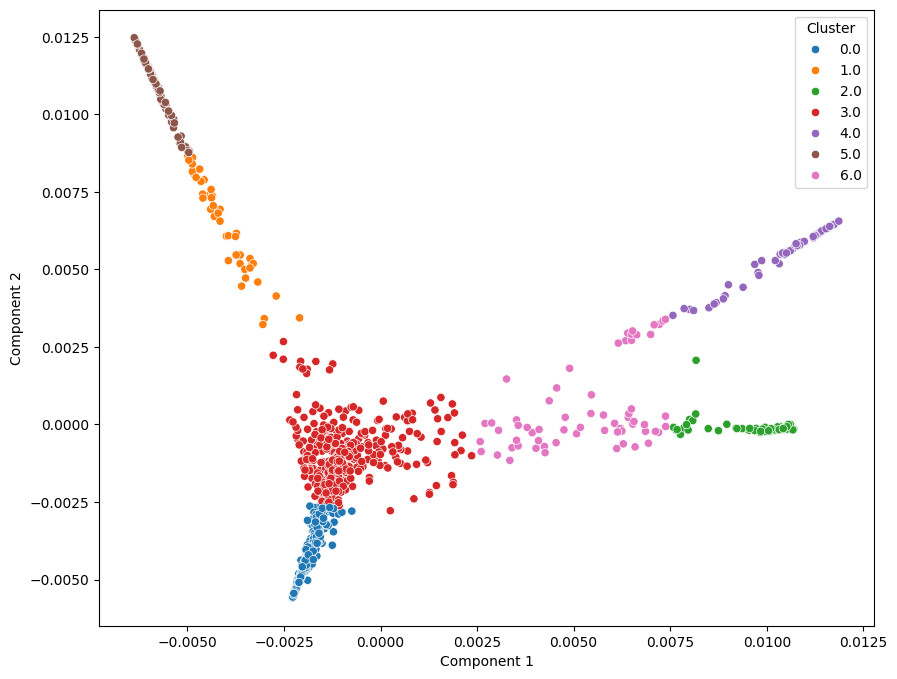

<Figure size 1000x800 with 0 Axes>

In [ ]:
from sklearn.manifold import SpectralEmbedding
vgg16_spec = SpectralEmbedding(n_components=2,
                             affinity='nearest_neighbors', # rbf
                             gamma=None,
                             random_state=42,
                             eigen_solver=None, # arpack lobpcg amg
                             n_neighbors=50,
                             n_jobs=-1
                            ).fit_transform(feat_vgg16)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans5_vgg16 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(vgg16_spec)
    # Assign clusters
labels=kmeans5_vgg16.labels_

title='VGG16 + Spectral 2 components'
# Evaluate and store metrics results)
append_dict(vgg16_results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(vgg16_spec,labels)

##### ResNet50 + SpectralEmbedding

,cluster,effectives
Category,,
Furniture,1,218
Baby,2,56
Watches,6,141
Decor,3,124
Kitchen,4,108
Beauty,5,75
Computers,0,328


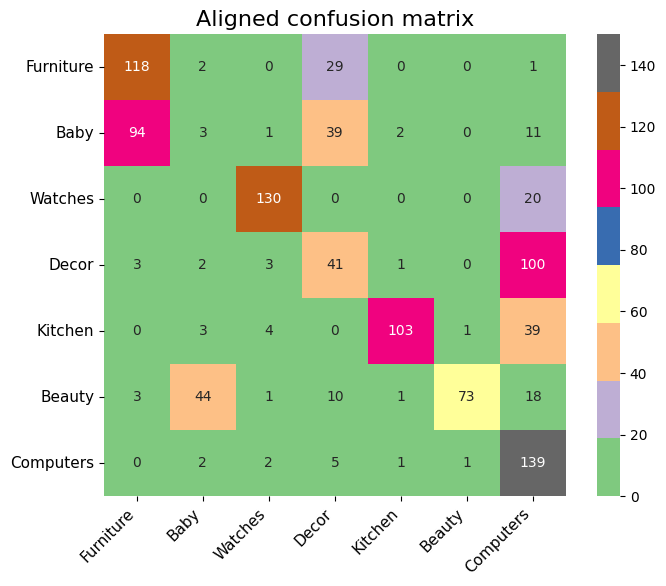

 ARI : 0.4085784946148968
              precision    recall  f1-score   support

   Furniture       0.54      0.79      0.64       150
        Baby       0.00      0.00      0.00       150
     Watches       0.92      0.87      0.89       150
       Decor       0.33      0.27      0.30       150
     Kitchen       0.95      0.69      0.80       150
      Beauty       0.89      0.78      0.83       150
   Computers       0.42      0.93      0.58       150

    accuracy                           0.62      1050
   macro avg       0.58      0.62      0.58      1050
weighted avg       0.58      0.62      0.58      1050

Clustering on ResNet50 + Spectral 2 components


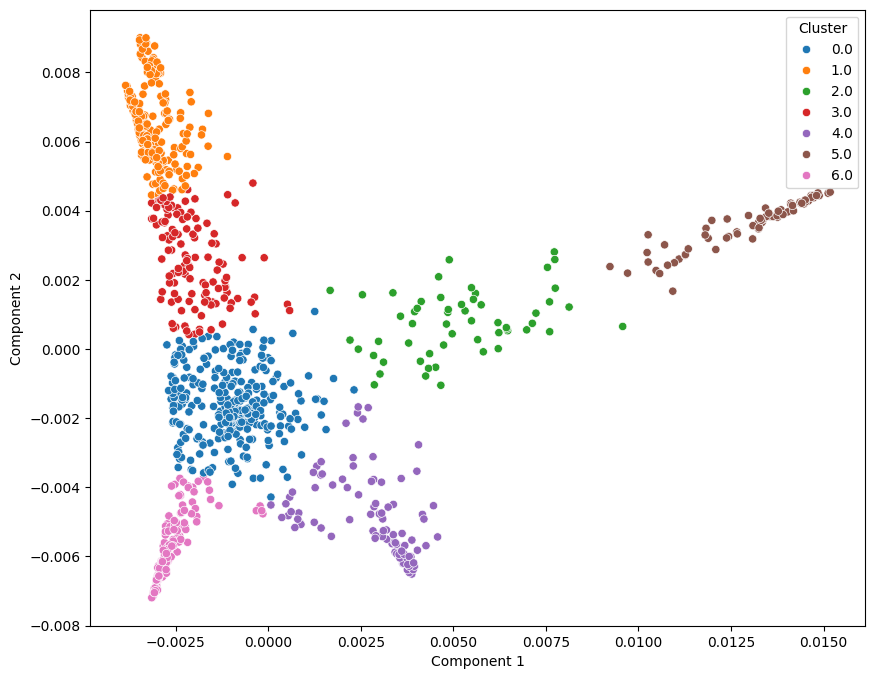

<Figure size 1000x800 with 0 Axes>

In [ ]:
from sklearn.manifold import SpectralEmbedding
rn50_spec = SpectralEmbedding(n_components=2,
                             affinity='nearest_neighbors', # rbf
                             gamma=None,
                             random_state=42,
                             eigen_solver=None, # arpack lobpcg amg
                             n_neighbors=50,
                             n_jobs=-1
                            ).fit_transform(feat_resnet50)

# Import KMeans clusterer
from sklearn.cluster import KMeans


kmeans5_rn50 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(rn50_spec)
    # Assign clusters
labels=kmeans5_rn50.labels_

title='ResNet50 + Spectral 2 components'
# Evaluate and store metrics results)
append_dict(rn50_results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering on '+title)

plot_clusters(rn50_spec,labels)

#### UMAP

* **Balanced structure preservation**: Maintains both local similarity relationships and global data patterns
* **Topological foundation**: Constructs representation based on manifold topology and fuzzy simplicial sets
* **Computational efficiency**: Delivers t-SNE-like quality with significantly better performance
* **Meaningful distance preservation**: Maintains more of the important distance relationships than t-SNE
* **Theoretical rigor**: Built on stronger mathematical foundations with clearer optimization objectives
* **Cluster separation clarity**: Produces well-defined clusters while preserving their relative positions

##### VGG16 + UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,cluster,effectives
Category,,
Furniture,5,126
Baby,1,218
Watches,0,138
Decor,6,225
Kitchen,2,80
Beauty,4,122
Computers,3,141


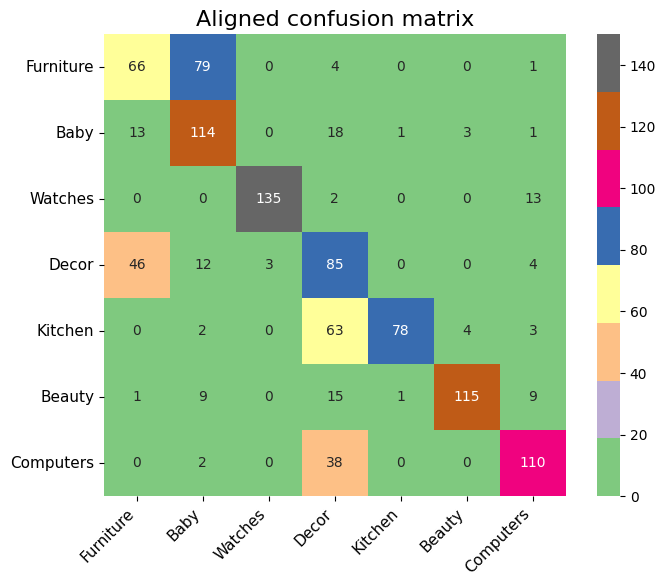

 ARI : 0.45370042469023963
              precision    recall  f1-score   support

   Furniture       0.52      0.44      0.48       150
        Baby       0.52      0.76      0.62       150
     Watches       0.98      0.90      0.94       150
       Decor       0.38      0.57      0.45       150
     Kitchen       0.97      0.52      0.68       150
      Beauty       0.94      0.77      0.85       150
   Computers       0.78      0.73      0.76       150

    accuracy                           0.67      1050
   macro avg       0.73      0.67      0.68      1050
weighted avg       0.73      0.67      0.68      1050

Clustering sur VGG16 + UMAP 2 components


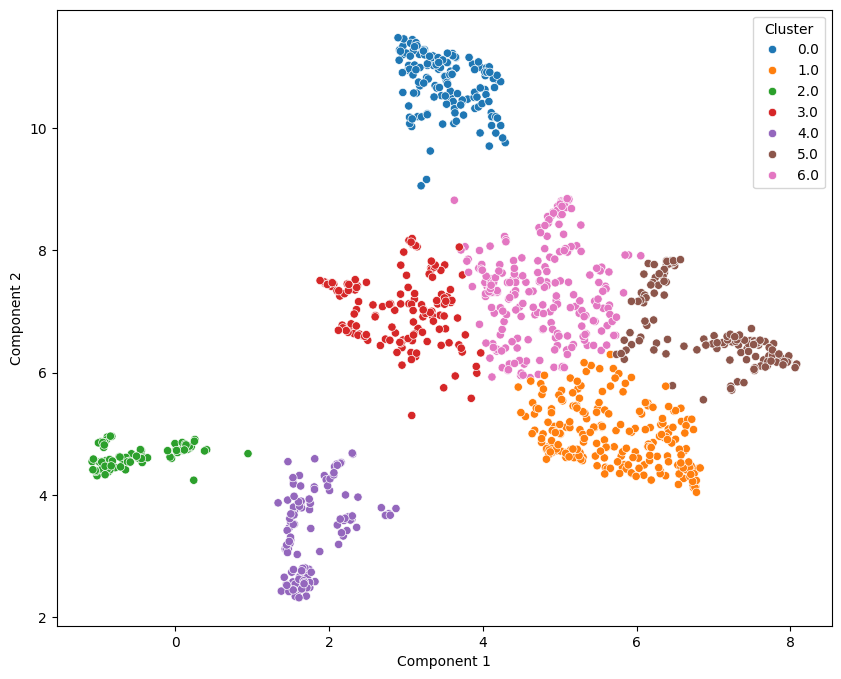

<Figure size 1000x800 with 0 Axes>

In [ ]:
import umap

Umap = umap.UMAP(
                n_neighbors=50,
                min_dist=0.1,
                n_components=2,
                metric='euclidean',
                random_state=42
    )
vgg16_umap = Umap.fit_transform(feat_vgg16)

kmeans6_vgg16 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(vgg16_umap)
    # Assign clusters
labels=kmeans6_vgg16.labels_

title='VGG16 + UMAP 2 components'
# Evaluate and store metrics results)
append_dict(vgg16_results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering sur '+title)

plot_clusters(vgg16_umap,labels)

##### ResNet50 + UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,cluster,effectives
Category,,
Furniture,5,109
Baby,4,201
Watches,3,172
Decor,0,128
Kitchen,1,121
Beauty,6,135
Computers,2,184


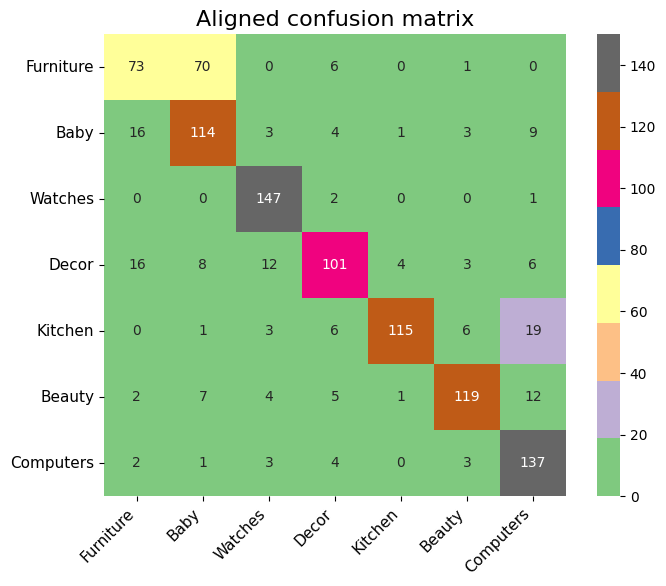

 ARI : 0.5735213417470404
              precision    recall  f1-score   support

   Furniture       0.67      0.49      0.56       150
        Baby       0.57      0.76      0.65       150
     Watches       0.85      0.98      0.91       150
       Decor       0.79      0.67      0.73       150
     Kitchen       0.95      0.77      0.85       150
      Beauty       0.88      0.79      0.84       150
   Computers       0.74      0.91      0.82       150

    accuracy                           0.77      1050
   macro avg       0.78      0.77      0.77      1050
weighted avg       0.78      0.77      0.77      1050

Clustering sur ResNet50 + UMAP 2 components


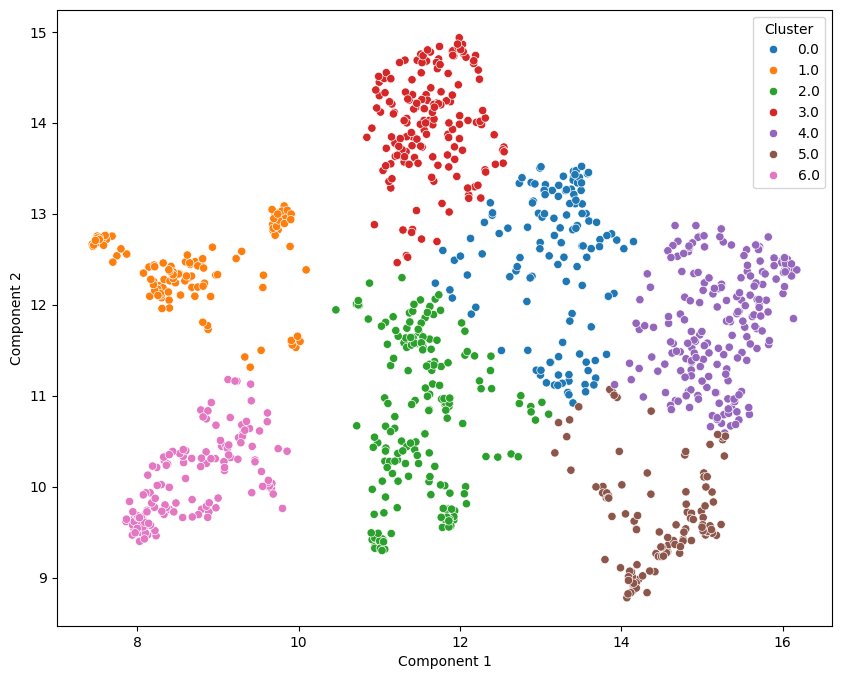

<Figure size 1000x800 with 0 Axes>

In [ ]:
import umap

Umap = umap.UMAP(
                n_neighbors=50,
                min_dist=0.1,
                n_components=2,
                metric='euclidean',
                random_state=42
    )
rn50_umap = Umap.fit_transform(feat_resnet50)

kmeans6_rn50 = KMeans(n_clusters=7, random_state=42,n_init=30).fit(rn50_umap)
    # Assign clusters
labels=kmeans6_rn50.labels_

title='ResNet50 + UMAP 2 components'
append_dict(rn50_results, {'title'   : title,
                     'metrics' : clustering_evaluate(labels, data.cat_code,cat['category'])
                     }
           )
# clustering_evaluate(labels, data.cat_code,cat['index'])
print('Clustering sur '+title)

plot_clusters(rn50_umap,labels)

# Résultats

## Performances depending on projection

In [ ]:
# Create data frame from resluts dictionaryy


def highlight_max(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]
def highlight_min(s):
    '''
    highlight the minmum in a Series red.
    '''
    is_max = s == s.min()
    return ['background-color: lightcoral' if v else '' for v in is_max]


# unpack tuples and create result data frame
def dict_to_df(dic):
    # dict to data frame
    results_all=pd.DataFrame(dic)
    # unpack metrics tuple
    results_all['precision']=[tup[0][0] for tup in results_all.metrics]
    results_all['recall']=[tup[0][1] for tup in results_all.metrics]
    results_all['f1_score']=[tup[0][2] for tup in results_all.metrics]
    results_all['ARI']=[tup[1] for tup in results_all.metrics]
    # drop tuples
    results_all.drop(['metrics'],axis=1,inplace=True)
    # set title as index
    results_all.set_index('title',inplace=True)
#     # columns to highligth
#     subset=['precision','recall','f1_score','ARI']
    # return dataframe
    return results_all.style.apply(highlight_max).apply(highlight_min).format('{:.2%}')

In [ ]:
vgg16_results_images = dict_to_df(vgg16_results)
vgg16_results_images

,precision,recall,f1_score,ARI
title,,,,
VGG16,79.08%,71.33%,71.29%,47.74%
"VGG16 + PCA (2 components, 14.53% explained variance)",49.37%,52.29%,48.21%,29.19%
VGG16 + T-SNE 2 components,78.34%,74.00%,74.36%,50.39%
VGG16 + MDS 2 components,55.25%,54.76%,54.70%,29.71%
VGG16 + Spectral 2 components,51.72%,56.10%,48.81%,31.87%
VGG16 + UMAP 2 components,72.86%,66.95%,68.12%,45.37%


In [ ]:
rn50_results_images = dict_to_df(rn50_results)
rn50_results_images

,precision,recall,f1_score,ARI
title,,,,
ResNet50,78.09%,70.29%,70.68%,46.32%
"ResNet50 + PCA (2 components, 11.98% explained variance)",54.94%,57.05%,53.51%,33.96%
ResNet50 + T-SNE 2 components,75.88%,75.43%,75.25%,54.99%
ResNet50 + MDS 2 components,43.94%,49.43%,45.62%,24.42%
ResNet50 + Spectral 2 components,58.06%,61.71%,57.81%,40.86%
ResNet50 + UMAP 2 components,77.96%,76.76%,76.53%,57.35%


## Visualisation of images in each cluster

Here you can find images samples regrouped in clusters according to projections having best ARI scores. They can eventually match with the categories labels.

In [ ]:
cat['category']

,category
0,Furniture
1,Baby
2,Watches
3,Decor
4,Kitchen
5,Beauty
6,Computers


### VGG16

In [ ]:
# Show a sample of 30 image in each cluster for visual verification
print('In cluster image with VGG16 features extractor ')
view_cluster(kmeans3_vgg16.labels_)

Output hidden; open in https://colab.research.google.com to view.

### ResNet50

In [ ]:
# Show a sample of 30 image in each cluster for visual verification
print('In cluster image with VGG16 features extractor ')
view_cluster(kmeans6_rn50.labels_)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(' Executé en : ', datetime.timedelta(seconds=(time.time() - start_time)))

 Executé en :  0:08:18.150024
